In [2]:
# 과대 적합 
## 일정 에포크 동안 훈련하면 검증 세트에서 모델 성능이 최고점에 도달한 다음 감소하기 시작한 것

# 과소 적합 
## 테스트 세트의 성능이 향상될 여지가 아직 있을 때 나타남
## 네트워크가 훈련 세트에서 적절한 패턴을 학습하지 못했다는 뜻


# 과대적합을 막는 가장 좋은 방법은 더 많은 훈련 데이터를 사용하는 것
# 데이터를 더 준비할 수 없을 때 그다음으로 가장 좋은 방법은 규제(regularization)와 같은 기법을 사용하는 것
    ## 모델이 저장할 수 있는 정보의 양과 종류에 제약을 부과하는 방법
    ## 두 가지 규제 기법인 가중치 규제와 드롭아웃(dropout)에 대해서 알아볼 것 
    
    
## 과대 적합을 방지하기 위해 널리 사용하는 방법
    # 1. 더 많은 훈련데이터를 모은다. 
    # 2. 네트워크 용량을 줄인다.
    # 3. 가중치 규제를 추가한다. 
    # 4. 드롭아웃을 추가한다. 
    # 5. 데이터 증식 (data-augmentation)
    # 6. 배치 정규화 (batch normalization)

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.13.1


In [4]:
# 문장을 멀티-핫 인코딩으로 변환할것 - 빠르게 과대적합 시켜주기 위해서
## 멀티-핫 인코딩 
    ## 멀티-핫 인코딩은 정수 시퀀스를 0과 1로 이루어진 벡터로 변환
    ## 시퀀스 [3, 5]를 인덱스 3과 5만 1이고 나머지는 모두 0인 10,000 차원 벡터로 변환한다는 의미

NUM_WORDS = 10000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension) 크기의 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # results[i]의 특정 인덱스만 1로 설정합니다
    return results


train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

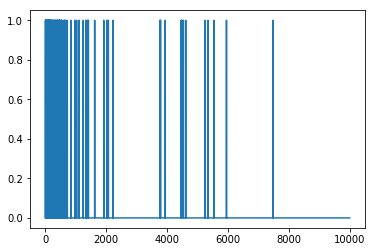

In [5]:
# 멀티-핫 벡터 중 한개 보기 
# 단어 인덱스는 빈도 순으로 정렬되어 있음 

plt.plot(train_data[0])

# 인덱스 0에 가까울수록 1이 많이 등장함

In [6]:
# 과대적합을 막는 가장 간단한 방법은 모델의 규모를 축소하는 것입니다. 
    ## 즉, 모델에 있는 학습 가능한 파라미터의 수를 줄입니다
    ## (모델 파라미터는 층(layer)의 개수와 층의 유닛(unit) 개수에 의해 결정됩니다). 

# 딥러닝에서는 모델의 학습 가능한 파라미터의 수를 종종 모델의 "용량(capacity)"이라고 말함


In [7]:
# 항상 기억해야 할 점은 딥러닝 모델이 훈련 세트에는 학습이 잘 되는 경향이 있지만 진짜 해결할 문제는 학습이 아니라 일반화라는 것

In [8]:
# 알맞은 모델의 크기를 찾으려면 비교적 적은 수의 층과 파라미터로 시작해서 검증 손실이 감소할 때까지 새로운 층을 추가하거나 층의 크기를 늘리는 것이 좋습니다. 

# Dense 층만 사용하는 간단한 기준 모델을 만들고 작은 규모의 버전와 큰 버전의 모델을 만들어 비교하겠습니다.

In [9]:
# 기준 모델 만들기 (16 = 2^4)

## Dense()의 첫번째 인자는 units - 현재 dense를 통해서 만들 hidden layer의 node의 수를 정의하는 것이다. 

baseline_model = keras.Sequential([
    # `.summary` 메서드 때문에 `input_shape`가 필요합니다
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

# baseline_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [10]:
# 만든 기준모델의 각 학습별 정보를 baseline_history 객체에 넣어준다. + 훈련 

baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Train on 25000 samples, validate on 25000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 11s - loss: 0.4784 - acc: 0.8054 - binary_crossentropy: 0.4784 - val_loss: 0.3340 - val_acc: 0.8783 - val_binary_crossentropy: 0.3340
Epoch 2/20
 - 9s - loss: 0.2462 - acc: 0.9138 - binary_crossentropy: 0.2462 - val_loss: 0.2854 - val_acc: 0.8878 - val_binary_crossentropy: 0.2854
Epoch 3/20
 - 8s - loss: 0.1778 - acc: 0.9390 - binary_crossentropy: 0.1778 - val_loss: 0.2971 - val_acc: 0.8823 - val_binary_crossentropy: 0.2971
Epoch 4/20
 - 8s - loss: 0.1439 - acc: 0.9512 - binary_crossentropy: 0.1439 - val_loss: 0.3373 - val_acc: 0.8708 - val_binary_crossentropy: 0.3373
Epoch 5/20
 - 8s - loss: 0.1180 - acc: 0.9614 - binary_crossentropy: 0.1180 - val_loss: 0.3445 - val_acc: 0.8733 - val_binary_crossentropy: 0.3445
Epoch 6/20
 - 8s - loss: 0.0971 - acc: 0.9709 - binary_crossentropy: 0.0971 - val_loss: 0.3757 - val_acc: 0.8701 - val_binary_crossentropy: 0.3757
Epoch 7/20
 - 8s - 

In [11]:
# 작은 모델 만들기 (적은 수의 은닉 유닛을 가진 모델 만들기) (2^2)

smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

smaller_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [12]:
# 같은 데이터를 이용해 작은 모델 훈련

smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 18s - loss: 0.5571 - acc: 0.7854 - binary_crossentropy: 0.5571 - val_loss: 0.4546 - val_acc: 0.8414 - val_binary_crossentropy: 0.4546
Epoch 2/20
 - 8s - loss: 0.3628 - acc: 0.8797 - binary_crossentropy: 0.3628 - val_loss: 0.3483 - val_acc: 0.8726 - val_binary_crossentropy: 0.3483
Epoch 3/20
 - 7s - loss: 0.2733 - acc: 0.9088 - binary_crossentropy: 0.2733 - val_loss: 0.3082 - val_acc: 0.8805 - val_binary_crossentropy: 0.3082
Epoch 4/20
 - 8s - loss: 0.2249 - acc: 0.9244 - binary_crossentropy: 0.2249 - val_loss: 0.2904 - val_acc: 0.8861 - val_binary_crossentropy: 0.2904
Epoch 5/20
 - 9s - loss: 0.1930 - acc: 0.9359 - binary_crossentropy: 0.1930 - val_loss: 0.2848 - val_acc: 0.8866 - val_binary_crossentropy: 0.2848
Epoch 6/20
 - 8s - loss: 0.1706 - acc: 0.9431 - binary_crossentropy: 0.1706 - val_loss: 0.2860 - val_acc: 0.8864 - val_binary_crossentropy: 0.2860
Epoch 7/20
 - 8s - loss: 0.1519 - acc: 0.9506 - binary_crossentropy

In [13]:
# 큰 모델 만들기 (2^9)
## 아주 큰 모델을 만들어 얼마나 빠르게 과대적합이 시작되는지 알아 볼 수 있슴.

bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 같은 데이터 이용해 큰 모델 훈련시키기 

bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 33s - loss: 0.3484 - acc: 0.8472 - binary_crossentropy: 0.3484 - val_loss: 0.3009 - val_acc: 0.8770 - val_binary_crossentropy: 0.3009
Epoch 2/20
 - 39s - loss: 0.1465 - acc: 0.9472 - binary_crossentropy: 0.1465 - val_loss: 0.3294 - val_acc: 0.8735 - val_binary_crossentropy: 0.3294
Epoch 3/20
 - 40s - loss: 0.0486 - acc: 0.9856 - binary_crossentropy: 0.0486 - val_loss: 0.4466 - val_acc: 0.8681 - val_binary_crossentropy: 0.4466
Epoch 4/20
 - 37s - loss: 0.0070 - acc: 0.9989 - binary_crossentropy: 0.0070 - val_loss: 0.5941 - val_acc: 0.8686 - val_binary_crossentropy: 0.5941
Epoch 5/20
 - 40s - loss: 6.8595e-04 - acc: 1.0000 - binary_crossentropy: 6.8595e-04 - val_loss: 0.6808 - val_acc: 0.8706 - val_binary_crossentropy: 0.6808
Epoch 6/20
 - 35s - loss: 2.1738e-04 - acc: 1.0000 - binary_crossentropy: 2.1738e-04 - val_loss: 0.7176 - val_acc: 0.8708 - val_binary_crossentropy: 0.7176
Epoch 7/20
 - 35s - loss: 1.3513e-04 - acc: 1.

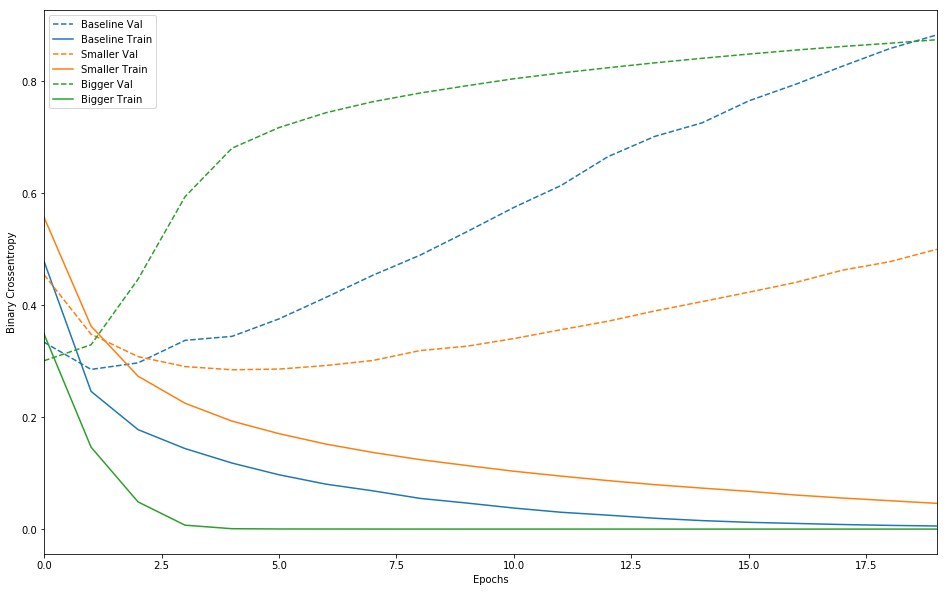

In [15]:
# 훈련 손실과 검증 손실 그래프 그리기 

## 실선 - 훈련손실 
## 점선 - 검증 손실 
    ### --> 낮은 검증 손실이 더 좋은 모델 
    
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

    
# 작은 네트워크가 기준 모델보다 더 늦게 과대 적합 시작 + 과대 적합 시작되고 훨씬 천천히 성능 감소
# 큰 네트워크는 거의 바로 첫번째 에포크 이후에 과대 적합 시작되고 훨신 심하게 과대적합 됨 
    ### 네트워크 용량이 많을수록 훈련 세트를 더 빠르게 모델링할 수 있다 --> 훈련 손실이 낮아짐 but 더 쉽게 과대적합 된다. 
    

In [ ]:
$ 과대적합 방지 - 가중치 규제하기 

* 오캄의 면도날 이론 -> 간단한 설명이 더 정확한 설명 -> 신경망으로 학습되는 모델에도 적용 -> 간단한 모델 -> 복잡한 것보다 과대적합되는 경향이 작다 

* 간단한 모델 -> 모델 파라미터의 분포를 봤을 때 엔트로피가 작은 모델 or 적은 파라미터를 가진 모델 

* 과대적합을 완화시키는 일반적인 방법은 가중치가 작은 값을 가지도록 네트워크의 복잡도에 제약을 가하는 것 
        -> 가중치 값의 분포를 좀 더 균일하게 만들어줌  = 가중치 규제 -> 네트워크의 손실함수에 큰 가중치에 해당하는 비용을 추가

        ** L1 loss : 모델이 예측하느 값과 라벨의 실제 값 차이의 절대값에 기초한 손실함수 -> L1loss 는 L2loss 보다 이상점에 둔감
        ** L2 loss : 선형 회귀에 사용되는 손실 함수 / 라벨에 있는 예에 대한 모델의 예측 값과 라벨의 실제 값 차이의 제곱을 계산한다 / 손실 함수는 제곱을 구하므로 부정확한 예측에 더 큰 영향을 준다 -> 그래서 제곱 손실은 L1loss보다 이상점에 민감하게 반응함
        
        -> 비용의 2가지 형태 
        
        ** L1 규제 : 가중치의 절대값에 비례하는 비용 추가 = 가중치의 L1norm을 추가 
        ** L2 규제(= 가중치 감쇠(weight decay)) : 가중치의 제곱에 비례하는 비용 추가 = 가중치의 L2norm의 제곱을 추가 
            
    

In [16]:
# L2 가중치 규제 추가해 보기 

## l2(0.001) : 네트워크의 전체 손실에 층에 있는 가중치 행렬의 모든 값이 <0.001 * weight_coefficient_value**2> 만큼 더해진다는 의미 
## 이런 페널티는 훈련할 때만 추가된다. 그래서 테스트 단계보다 훈련단계에서 네트워크 손실이 더큼 


l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 16s - loss: 0.5211 - acc: 0.8152 - binary_crossentropy: 0.4785 - val_loss: 0.3703 - val_acc: 0.8803 - val_binary_crossentropy: 0.3253
Epoch 2/20
 - 9s - loss: 0.2953 - acc: 0.9102 - binary_crossentropy: 0.2454 - val_loss: 0.3368 - val_acc: 0.8872 - val_binary_crossentropy: 0.2835
Epoch 3/20
 - 8s - loss: 0.2440 - acc: 0.9338 - binary_crossentropy: 0.1881 - val_loss: 0.3481 - val_acc: 0.8832 - val_binary_crossentropy: 0.2905
Epoch 4/20
 - 9s - loss: 0.2244 - acc: 0.9426 - binary_crossentropy: 0.1649 - val_loss: 0.3720 - val_acc: 0.8756 - val_binary_crossentropy: 0.3110
Epoch 5/20
 - 9s - loss: 0.2082 - acc: 0.9511 - binary_crossentropy: 0.1462 - val_loss: 0.3816 - val_acc: 0.8752 - val_binary_crossentropy: 0.3188
Epoch 6/20
 - 8s - loss: 0.1963 - acc: 0.9561 - binary_crossentropy: 0.1326 - val_loss: 0.3967 - val_acc: 0.8723 - val_binary_crossentropy: 0.3325
Epoch 7/20
 - 8s - loss: 0.1889 - acc: 0.9592 - binary_crossentropy

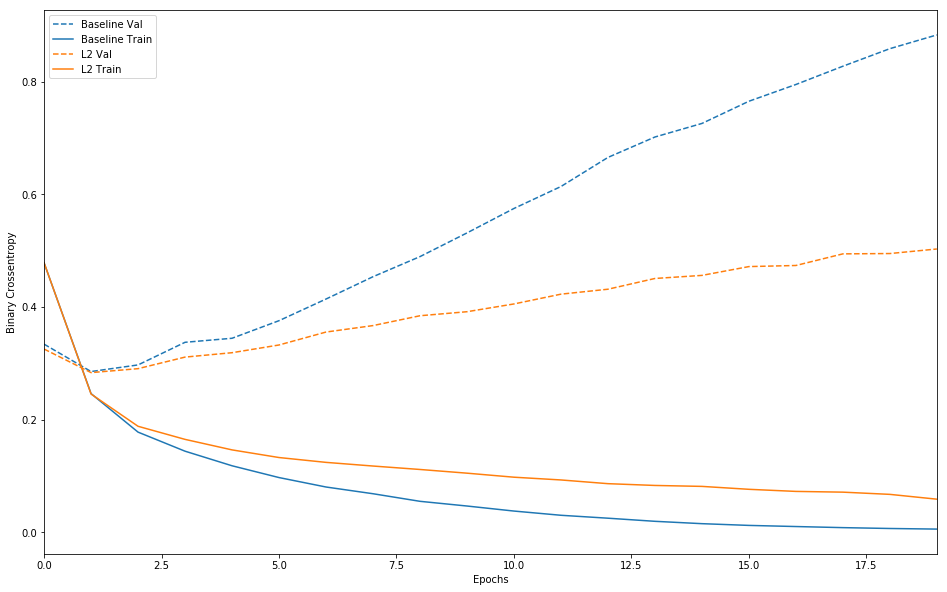

In [17]:
# L2 규제의 효과 확인하기 

plot_history([('baseline', baseline_history),
              ('l2', l2_model_history)])

## L2 규제를 적용한 모델이 기본 모델보다 과대적합에 훨씬 잘 견디고 있음 

In [ ]:
$ 과대적합 방지 - 드롭아웃 추가하기 


드롭아웃을 층에 적용하면 훈련하는 동안 층의 출력 특성을 랜덤하게 끕니다(즉, 0으로 만듭니다)
훈련하는 동안 어떤 입력 샘플에 대해 [0.2, 0.5, 1.3, 0.8, 1.1] 벡터를 출력하는 층이 있다고 가정해 보죠.
드롭아웃을 적용하면 이 벡터에서 몇 개의 원소가 랜덤하게 0이 됩니다. 예를 들면, [0, 0.5, 1.3, 0, 1.1]가 됩니다.

"드롭아웃 비율"은 0이 되는 특성의 비율입니다. 
비율을 보통 0.2에서 0.5 사이를 사용합니다. 테스트 단계에서는 어떤 유닛도 드롭아웃하지 않습니다. 
훈련 단계보다 더 많은 유닛이 활성화되기 때문에 균형을 맞추기 위해 층의 출력 값을 드롭아웃 비율만큼 줄입니다.

keras.layers.Dropout() - 이것을 이용해 네트워크에 드롭아웃을 추가할 수 있다. / 이 층은 바로 이전 층의 출력에 드롭아웃을 적용한다. 



In [18]:
# 두개의 드롭아웃층을 추가하여 과대적합이 얼마나 감소하는지 알아보기 

dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 10s - loss: 0.6261 - acc: 0.6448 - binary_crossentropy: 0.6261 - val_loss: 0.4800 - val_acc: 0.8468 - val_binary_crossentropy: 0.4800
Epoch 2/20
 - 8s - loss: 0.4615 - acc: 0.8089 - binary_crossentropy: 0.4615 - val_loss: 0.3405 - val_acc: 0.8822 - val_binary_crossentropy: 0.3405
Epoch 3/20
 - 9s - loss: 0.3631 - acc: 0.8642 - binary_crossentropy: 0.3631 - val_loss: 0.2956 - val_acc: 0.8859 - val_binary_crossentropy: 0.2956
Epoch 4/20
 - 9s - loss: 0.2981 - acc: 0.8940 - binary_crossentropy: 0.2981 - val_loss: 0.2819 - val_acc: 0.8868 - val_binary_crossentropy: 0.2819
Epoch 5/20
 - 9s - loss: 0.2536 - acc: 0.9126 - binary_crossentropy: 0.2536 - val_loss: 0.2801 - val_acc: 0.8884 - val_binary_crossentropy: 0.2801
Epoch 6/20
 - 9s - loss: 0.2282 - acc: 0.9218 - binary_crossentropy: 0.2282 - val_loss: 0.2919 - va

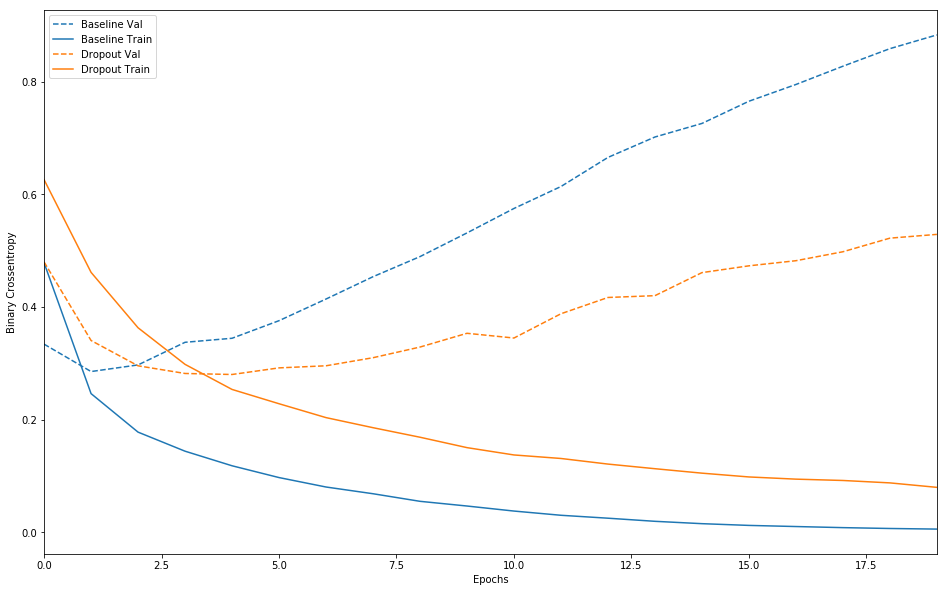

In [19]:
# 드롭아웃 추가의 효과 확인하기 

plot_history([('baseline', baseline_history),
              ('dropout', dpt_model_history)])

# 향상되었음을 확인 가능 